## Obtaining financial data for Amazon

TO DO:

~~1. Restore the list of indicators and the query to select EPS~~
2. Find underlying EPS figures -- earnings after dividends and number of shares outstanding.
3. Look at current trends around PE
4. If PE hits 20, how much will earnings be?
5. Possible to find the current short interest?


In [2]:
import requests
import config
import pandas as pd
from StringIO import StringIO

#### Company list

In [2]:
base = 'https://api.usfundamentals.com/v1/'
param = 'companies/xbrl?&format=json&token={}'.format(config.us_fun_key)

In [3]:
r = requests.get('{}{}'.format(base, param)).json()

In [4]:
companies = pd.DataFrame(r).set_index('name_latest')['company_id'].to_dict()

### Earnings per share

In [5]:
base = 'https://api.usfundamentals.com/v1/indicators/xbrl?'
param = 'companies=1018724&frequency=q&token={}'.format(config.us_fun_key)
#ind = 'indicators=EarningsPerShareDiluted&'
#param = '{}companies=1018724&frequency=q&token={}'.format(ind, config.us_fun_key)

In [6]:
r = requests.get('{}{}'.format(base, param))

#### List of Amazon Indicators

In [7]:
indicators = pd.read_csv(StringIO(r.text))['indicator_id'].unique()
#indicators

In [8]:
inds = ['EarningsPerShareDiluted', 'WeightedAverageNumberOfDilutedSharesOutstanding', 'NetIncomeLoss']

In [9]:
df = pd.read_csv(StringIO(r.text)).query('indicator_id == @inds')
df = df.set_index(['company_id', 'indicator_id']).T
df['date'] = df.index.map(lambda x: pd.Period(x).end_time.date())
df.columns = ['EPS', 'Profit', 'Shares', 'date']
df = df.set_index('date')

# Trailing 12 months EPS
df['EPS_TTM'] = df['EPS'].rolling(4).sum()

### Stock price history

In [10]:
base = 'https://www.quandl.com/api/v3/datatables/WIKI/PRICES.json?'
param = 'ticker=AMZN&qopts.columns=date,close&api_key={}'.format(config.quandl_key)

In [11]:
r2 = requests.get('{}{}'.format(base, param)).json()

In [12]:
df2 = pd.DataFrame(r2['datatable']['data']).set_index(0)
df2.columns = ['Price']

# Fill in missing date values with last available price
idx = pd.date_range(df2.index[0], df2.index[-1])
df2.index = pd.DatetimeIndex(df2.index)
df2 = df2.reindex(idx, fill_value=None).fillna(method='ffill')

#### Merge price and fundamentals data

In [13]:
df = df.merge(df2, left_index=True, right_index=True, how='left')
df['PE_ratio'] = df['Price'] / df['EPS_TTM']

In [14]:
df.to_csv('Amazon_Fundamentals.csv')

In [15]:
df

,EPS,Profit,Shares,EPS_TTM,Price,PE_ratio
date,,,,,,
2011-03-31,0.44,201000000.0,459000000.0,NaN,180.130,NaN
2011-06-30,0.41,191000000.0,460000000.0,NaN,204.490,NaN
2011-09-30,0.14,63000000.0,461000000.0,NaN,216.230,NaN
2011-12-31,0.38,176000000.0,-919000000.0,1.37,173.100,126.350365
2012-03-31,0.28,130000000.0,460000000.0,1.21,202.510,167.363636
2012-06-30,0.01,7000000.0,458000000.0,0.81,228.350,281.913580
2012-09-30,-0.60,-274000000.0,460000000.0,0.07,254.320,3633.142857
2012-12-31,0.22,98000000.0,-925000000.0,-0.09,250.870,-2787.444444
2013-03-31,0.18,82000000.0,463000000.0,-0.19,266.490,-1402.578947


In [9]:
import matplotlib
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('Amazon_Fundamentals.csv')
df['q'] = [pd.to_datetime(df['date'][x]).quarter for x, y in df.iterrows()]
df['y'] = [pd.to_datetime(df['date'][x]).year for x, y in df.iterrows()]

In [34]:
df['yq'] = ['{} Q{}'.format(df['y'][x], df['q'][x]) for x, y in df.iterrows()]

In [38]:
df = df.set_index('yq')['Profit'].divide(1000000)

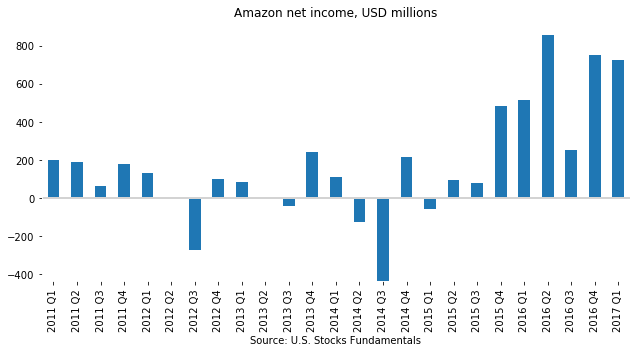

In [42]:
%matplotlib inline
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
df.plot(figsize=(9, 5), kind='bar', title='Amazon net income, USD millions')
plt.axhline(0, color='lightgray', lw=2)
plt.xlabel('Source: U.S. Stocks Fundamentals')
plt.tight_layout()
plt.savefig('AMZN_NI.png')